In [1]:
import fenics as fn
import numpy as np
#
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

PDE Problem:

$$
\left\{
\begin{array}{rlc}
\varepsilon u_x(x,y) + u(x,y) &= f(x,y) & \text{ in }(0,1)\times(0,1) \\
u(0,y) &= 0 & 
\end{array}
\right.
$$

Variational formulation:
$$\int_{\Omega} (\varepsilon u_x + u) (\varepsilon v_x + v) = \int_{\Omega} f (\varepsilon v_x + v), \quad\forall v \in H^{1}$$

In [2]:
#
def biliniear_form_func(u,v,eps=0.001):
    aux = (eps*u.dx(0) + u)*(eps*v.dx(0) + v)*(fn.dx)
    return aux
# 
def rhs_func(f,v,eps=0.001):
    aux = f*(eps*v.dx(0) + v)*(fn.dx)
    return aux

**epsilon**

In [3]:
eps = .5

**Mesh to compute the error**

In [4]:
mesh_fine = fn.UnitSquareMesh(128,128)
U_fine = fn.FunctionSpace(mesh_fine,'CG',1)

**Analytical solution**

In [5]:
u_exact = fn.Expression('x[1]< 0.5 ? 1. - exp(-x[0]/eps) : 0.',eps = eps, degree=2)
u_exact_fn = fn.Function(U_fine)
u_exact_fn.interpolate(u_exact)

**Rhs function**

In [6]:
f = fn.Expression('x[1]< 0.5 ? 1.: 0.',degree=0)

**Convergence error**

In [10]:
N_list = [2,4,8,16,32,64]
error_list = []
n_elem_list = []
for N in N_list:
    mesh = fn.UnitSquareMesh(N,N)
    #fn.plot(mesh)
    #plt.show()
    # FE space
    Uh = fn.FunctionSpace(mesh,'CG',1)
    n_elem = Uh.dim()
    # Boundary condition
    g = fn.Constant(0.)
    bc_gamma = fn.DirichletBC(Uh,g,'x[0]<DOLFIN_EPS')
    # Trial and test functions
    uh = fn.TrialFunction(Uh)
    vh = fn.TestFunction(Uh)
    # bilinear form and rhs
    b = biliniear_form_func(uh,vh,eps)
    l = rhs_func(f,vh,eps)
    # Linear system
    B, L = fn.assemble_system(b,l,bc_gamma)
    # Exporting matrix and rhs vector
    B_np = B.array()
    L_np = L[:]
    # solving linear system
    vec = np.linalg.solve(B_np,L_np)
    uh_sol = fn.Function(Uh)
    uh_sol.vector()[:] = vec
    # Create a fine-mesh FE function
    uh_fine = fn.Function(U_fine)
    # interpolate the LSQ solution into the fine-mesh FE function
    uh_fine.interpolate(uh_sol)
    # compute the square of L2-norm
    error2 = fn.assemble((uh_fine - u_exact)**2*(fn.dx))
    # we take the square root of the above
    error = np.sqrt(error2)
    # save it in the lists
    error_list.append(error)
    n_elem_list.append(n_elem)
    print(error)

0.1676050162111665
0.1185443342477913
0.08339480569674027
0.05847885038533499
0.04073719954897585
0.027930380478312235


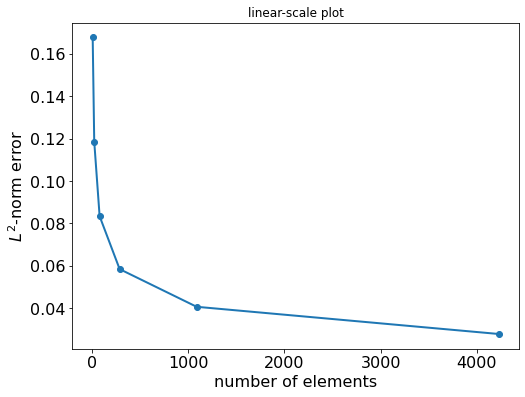

In [39]:
fig, ax = plt.subplots(figsize=(8,6))
#
plt.plot(n_elem_list,error_list,
         color='tab:blue',
         linestyle='-',
         marker='o',
         linewidth=2.0
        )
#
plt.ylabel(r'$L^2$-norm error',fontsize=16) # "r" means raw sequence
plt.yticks(fontsize=16)
plt.xlabel('number of elements',fontsize=16)
plt.xticks(fontsize=16)
#
plt.title('linear-scale plot')
#
plt.show()

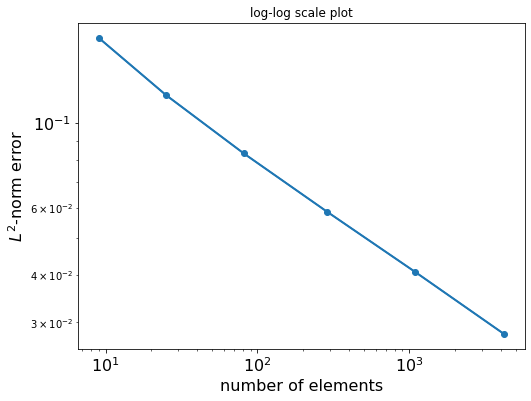

In [38]:
fig, ax = plt.subplots(figsize=(8,6))
#
plt.loglog(n_elem_list,error_list)
plt.plot(n_elem_list,error_list,
         color='tab:blue',
         linestyle='-',
         marker='o',
         linewidth=2.0
        )
#
plt.ylabel(r'$L^2$-norm error',fontsize=16) # "r" means raw sequence
plt.yticks(fontsize=16)
plt.xlabel('number of elements',fontsize=16)
plt.xticks(fontsize=16)
#
plt.title('log-log scale plot')
#
plt.show()

Calling FFC just-in-time (JIT) compiler, this may take some time.
0.03756636627747744